In [26]:
import pandas as pd
import nibabel as nib
%matplotlib inline
import matplotlib.pyplot as plt
results = '/rsrch1/ip/rglenn1/data/results/unet_full_detection_dice_performance.csv'
hcc_results = pd.DataFrame(pd.read_csv(results))
id = hcc_results['id']
id

FileNotFoundError: [Errno 2] No such file or directory: '/rsrch1/ip/rglenn1/data/results/unet_full_detection_dice_performance.csv'

In [ ]:

import numpy as np
import pandas as pd

titlename = 'unet_full'
savePath = '/rsrch1/ip/rglenn1/data/results'


hcc_results = pd.DataFrame(pd.read_csv(results))


Liver_dice = hcc_results['Liver_dice']
Liver_haus95 = hcc_results['Liver_haus95']
id = hcc_results['id']


patientID = hcc_results.id.unique()
Liver_dice = []
Liver_haus95 = []
print(len(patientID))
for patid in patientID:
    tmp = hcc_results.loc[hcc_results['id'] == patid]
    Liver_dice.append(np.mean(tmp['Liver_dice']))
    tmp = hcc_results.loc[hcc_results['id'] == patid]
    Liver_haus95.append(np.mean(tmp['Liver_haus95']))

id =patientID
yDice = [x for _, x in sorted(zip(id, Liver_dice))]
yHaus95 = [x for _, x in sorted(zip(id, Liver_haus95))]
x = range(len(id))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Patient ID')
ax1.set_ylabel('Dice coefficient', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, yDice, linestyle="-", marker="o", label='Dice coefficient', color=color)
ax1.set_ylim(0, 1.05*max(yDice))


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('HD Distance', color=color)
ax2.plot(x, yHaus95, linestyle="-", marker="o",  label='95% HD Truth & Prediction', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.05*max(yHaus95))

fig.tight_layout()

ax2.set_title(titlename)

plt.savefig(savePath + "/" + titlename + '.png', bbox_inches="tight")
plt.show() 
print(id[16])

In [ ]:
import numpy as np

headers = [titlename, "Mean", "Median", "Min", "Max", "Std"]

diceList = ["Dice Similarity Coefficient (" + titlename + ")", np.mean(yDice), np.median(yDice),  min(yDice), max(yDice), np.std(yDice)]
hdList = ["95th--percentile Hausdorff Distance (" + titlename + ")", np.mean(yHaus95), np.median(yHaus95),  min(yHaus95), max(yHaus95), np.std(yHaus95)]
data = pd.DataFrame([ diceList, hdList], columns=headers)
#data.to_csv('Data.csv', mode='a', index=False, header=False )

print(data)

In [29]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import numpy as np
import os

patientID = '1052473'
patientID = '1091400'
pred ='/rsrch1/ip/rglenn1/data/predictions/' + patientID +'.nii.gz'
truth = '/rsrch1/ip/rglenn1/data/Processed/' + patientID +'/Truth.raw.nii.gz'
art = '/rsrch1/ip/rglenn1/data/Processed/' + patientID +'/Art.raw.nii.gz'
pre = '/rsrch1/ip/rglenn1/data/Processed/' + patientID +'/Pre.raw.nii.gz'
ven = '/rsrch1/ip/rglenn1/data/Processed/' + patientID +'/Ven.raw.nii.gz'
 
img_pred = nib.load(pred).get_fdata()
img_truth = nib.load(truth).get_fdata()
img_art = nib.load(art).get_fdata()
img_ven = nib.load(ven).get_fdata()
img_pre = nib.load(pre).get_fdata()



def convertNsave(image2d, filepath, index=0):
    """
    `arr`: parameter will take a numpy array that represents only one slice.
    `file_dir`: parameter will take the path to save the slices
    `index`: parameter will represent the index of the slice, so this parameter will be used to put 
    the name of each slice while using a for loop to convert all the slices
    """
    image2d = image2d.astype(np.uint16)

    #print("Setting file meta information...")
    # Populate required values for file meta information

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  
    ds = Dataset()
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.PatientName = "TestFirstname"
    ds.PatientID = patientID

    ds.Modality = "MR"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SamplesPerPixel = 1
    ds.HighBit = 15

    ds.ImagesInAcquisition = "1"

    ds.Rows = image2d.shape[0]
    ds.Columns = image2d.shape[1]
    ds.InstanceNumber = 1

    ds.ImagePositionPatient = r"0\0\1"
    ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.RescaleIntercept = "0"
    ds.RescaleSlope = "1"
    ds.PixelSpacing = r"1\1"
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 1

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    #print("Setting pixel data...")
    ds.PixelData = image2d.tobytes()

    ds.save_as(filepath)

def createDICOM(img_array):

    cnt = 0
    number_slices = img_array.shape[2]
    dirpath = '/rsrch1/ip/rglenn1/data/predictions/' + patientID
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
    for slice_ in range(number_slices):

        fileName = patientID + "_" + str(cnt)

        filepath = os.path.join(dirpath, fileName +'.dcm')
        convertNsave(img_pred[:,:,slice_], filepath, cnt)
        cnt += 1
createDICOM(img_ven)
print(img_pred.shape)
# num = 60
# plt.imshow(img_pred[:,:,num])
# plt.imshow(img_art[:,:,num])
# plt.imshow(img_truth[:,:,num])

(576, 468, 104)


In [ ]:
from os.path import dirname, join
from pprint import pprint
import numpy as np
import ipywidgets as ipyw
from ipywidgets import interact
import matplotlib.pyplot as plt
import nibabel as nib
class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed.
Arguments:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('gray'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, figsize=(100,100), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.vol1 = np.transpose(self.volume, [1,2,0])
        self.vol2 = np.rot90(np.transpose(self.volume, [2,0,1]), 3) #rotate 270 degrees
        self.vol3 = np.transpose(self.volume, [0,1,2])
        maxZ1 = self.vol1.shape[2] - 1
        maxZ2 = self.vol2.shape[2] - 1
        maxZ3 = self.vol3.shape[2] - 1
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))
    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.vol1[:,:,z1], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        ax[1].imshow(self.vol2[:,:,z2], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        ax[2].imshow(self.vol3[:,:,z3], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        plt.show()

In [10]:
from os.path import dirname, join
from pprint import pprint
import numpy as np
import ipywidgets as ipyw
from ipywidgets import interact
import matplotlib.pyplot as plt
import nibabel as nib
class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed.
Arguments:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('gray'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, figsize=(100,100), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.vol1 = np.transpose(self.volume, [1,2,0])
        self.vol2 = np.rot90(np.transpose(self.volume, [2,0,1]), 3) #rotate 270 degrees
        self.vol3 = np.transpose(self.volume, [0,1,2])
        maxZ1 = self.vol1.shape[2] - 1
        maxZ2 = self.vol2.shape[2] - 1
        maxZ3 = self.vol3.shape[2] - 1
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))
    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.vol1[:,:,z1], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        ax[1].imshow(self.vol2[:,:,z2], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        ax[2].imshow(self.vol3[:,:,z3], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        plt.show()

In [12]:
IMG_FILE = art
ImageSliceViewer3D(nib.load(IMG_FILE).slicer[:,:,:].get_fdata())

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

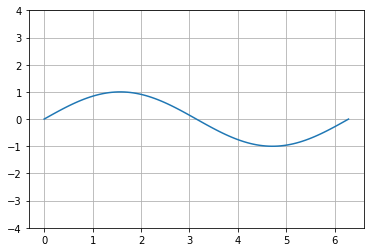

In [7]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@ipyw.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')